<a href="https://colab.research.google.com/github/rahiakela/tensorflow-computer-vision-cookbook/blob/main/09-localizing-elements-in-images-with-object-detection/01_creating_object_detector_with_image_pyramids_and_sliding_windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating an object detector with image pyramids and sliding windows

Object detection is one of the most common yet challenging tasks in computer vision. It's a natural evolution of image classification, where our goal is to work out what is in an image. On the other hand, object detection is not only concerned with the content of an image but also with the location of elements of interest in a digital image.

As with many other well-known tasks in computer vision, object detection has long been addressed with a wide array of techniques, ranging from naïve solutions (such as object matching) to machine learning-based ones (such as Haar Cascades). Nonetheless, the most effective detectors nowadays are powered by deep learning.

Implementing state-of-the-art object detectors (such as You Only Look Once (YOLO) and Fast Region-based Convolutional Neural Network (Fast R-CNN) from scratch is a very challenging task. However, there are many pre-trained solutions we can leverage, not only to make predictions but also to train our own models from zero.

## Setup

In [24]:
import cv2
import imutils
import numpy as np
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_resnet_v2 import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [2]:
!wget -q https://github.com/rahiakela/tensorflow-computer-vision-cookbook/raw/main/09-localizing-elements-in-images-with-object-detection/images/dog.jpg

##Overview

Traditionally, object detectors have worked following an iterative algorithm whereby a window is slid across the image, at different scales, in order to detect potential objects at every location and perspective. Although this approach is outdated due to its noticeable drawbacks, it has the great
advantage of being agnostic about the type of image classifier we use, meaning we can use it as a framework to turn any classifier into an object detector. This is precisely what we'll do in this first recipe!

## Defining ObjectDetector class

In [20]:
# let's define our object detector class,
class ObjectDetector(object):

  def __init__(self, classifier, preprocess_fn=lambda x: x, input_size=(299, 299), confidence=0.98, window_step_size=16, pyramid_scale=1.5, roi_size=(200, 150), nms_threshold=0.3):
    self.classifier = classifier
    self.preprocess_fn = preprocess_fn 
    self.input_size = input_size 
    self.confidence = confidence 
    self.window_step_size = window_step_size 
    self.pyramid_scale = pyramid_scale 
    self.roi_size = roi_size 
    self.nms_threshold = nms_threshold 

  def sliding_window(self, image):
    """
    A generator function that extracts portions of the input image, with dimensions equal to self.roi_size. 
    It's going to be slid across the image, both horizontally and vertically, at a rate of self.window_step_size pixels at a time
    """
    for y in range(0, image.shape[0], self.window_step_size):
      for x in range(0, image.shape[1], self.window_step_size):
        y_slice = slice(y, y + self.roi_size[1], 1)
        x_slice = slice(x, x + self.roi_size[0], 1)

        yield x, y, image[y_slice, x_slice]

  def pyramid(self, image):
    """
    A generator function that will generates smaller and smaller copies of the input image, until a minimum size is met (akin to the levels of a pyramid)
    """
    yield image

    while True:
      width = int(image.shape[1] / self.pyramid_scale)
      image = imutils.resize(image, width=width)

      if (image.shape[0] < self.roi_size[1] or image.shape[1] < self.roi_size[0]):
        break

      yield image

  def non_max_suppression(self, boxes, probabilities):
    """
    Because sliding a window across the same image at different scales is very prone
    to producing many detections related to the same object, we need a way to keep
    duplicates at a minimum using non-max suppression.
    """
    if len(boxes) == 0:
      return

    if boxes.dtype.kind == "i":
      boxes = boxes.astype(np.float)

    pick = []

    x_1 = boxes[:, 0]
    y_1 = boxes[:, 1]
    x_2 = boxes[:, 2]
    y_2 = boxes[:, 3]

    area = (x_2 - x_1 + 1) * (y_2 - y_1 + 1)
    indexes = np.argsort(probabilities)

    """
    We start by computing the area of all bounding boxes, and also sort them by their
    probability, in increasing order. Now, we'll pick the index of the bounding box
    with the highest probability, and add it to our final selection (pick) until we have
    indexes left to trim down.
    """
    while len(indexes) > 0:
      last = len(indexes) - 1
      i = indexes[last]
      pick.append(i)

      """
      We compute the overlap between the picked bounding box and the other ones,
      and then get rid of those boxes where the overlap is higher than self.nms_
      threshold, which means that they probably refer to the same object.
      """
      xx_1 = np.maximum(x_1[i], x_1[indexes[:last]])
      yy_1 = np.maximum(y_1[i], y_1[indexes[:last]])
      xx_2 = np.maximum(x_2[i], x_2[indexes[:last]])
      yy_2 = np.maximum(y_2[i], y_2[indexes[:last]])

      width = np.maximum(0, xx_2 - xx_1 + 1)
      height = np.maximum(0, yy_2 - yy_1 + 1)

      overlap = (width * height) / area[indexes[:last]]

      redundant_boxes = np.where(overlap > self.nms_threshold)[0]
      to_delete = np.concatenate(([last], redundant_boxes))
      indexes = np.delete(indexes, to_delete)

    return boxes[pick].astype(np.int)

  def detect(self, image):
    """
    This method ties the object detection algorithm together. We start by
    defining a list of regions of interest (rois) and their corresponding locations(coordinates in the original image).
    """
    rois = []
    locations = []

    """
    we'll generate different copies of the input image at several scales using the
    pyramid() generator, and at each level, we'll slide a window (with the sliding_
    windows() generator) to extract all possible ROIs.
    """
    for img in self.pyramid(image):
      scale = image.shape[1] / float(img.shape[1])

      for x, y, roi_original in self.sliding_window(img):
        x = int(x * scale)
        y = int(y * scale)
        w = int(self.roi_size[0] * scale)
        h = int(self.roi_size[1] * scale)

        roi = cv2.resize(roi_original, self.input_size)
        roi = img_to_array(roi)
        roi = self.preprocess_fn(roi)

        rois.append(roi)
        locations.append((x, y, x + w, y + h))

    rois = np.array(rois, dtype=np.float32)

    # Pass all ROIs through the classifier at once
    predictions = self.classifier.predict(rois)
    predictions = imagenet_utils.decode_predictions(predictions, top=1)

    # Build a dict to map each label produced by the classifier to all the bounding boxes and their probabilities
    labels = {}
    for i, pred in enumerate(predictions):
      _, label, proba = pred[0]

      if proba >= self.confidence:
        box = locations[i]

        label_detections = labels.get(label, [])
        label_detections.append({"box": box, "proba": proba})
        labels[label] = label_detections

    return labels

##Load InceptionResnetV2 model

We will instantiate an InceptionResnetV2 network trained on ImageNet to use as our classifier and pass it to a new ObjectDetector. Notice that we're also passing the `preprocess_function` as input.

In [21]:
model = InceptionResNetV2(weights="imagenet", include_top=True)
object_detector = ObjectDetector(model, preprocess_input)

## Making prediction

Let's load the input image, resize it to a width of 600 pixels maximum (the height will be computed accordingly to preserve the aspect ratio), and run it through the object detector.

In [22]:
image = cv2.imread("dog.jpg")
image = imutils.resize(image, width=600)
labels = object_detector.detect(image)

Let's go over all the detections corresponding to each label, and first draw all the bounding boxes.

In [23]:
GREEN = (0, 255, 0)
for i, label in enumerate(labels.keys()):
  clone = image.copy()

  for detection in labels[label]:
    box = detection["box"]
    probability = detection["proba"]

    x_start, y_start, x_end, y_end = box
    cv2.rectangle(clone, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
  cv2.imwrite(f"before_{i}.jpg", clone)

  # Then, use Non-Maximum Suppression (NMS) to get rid of duplicates and draw the surviving bounding boxes
  clone = image.copy()
  boxes = np.array([d['box'] for d in labels[label]])
  probas = np.array([d['proba'] for d in labels[label]])
  boxes = object_detector.non_max_suppression(boxes, probas)

  for x_start, y_start, x_end, y_end in boxes:
    cv2.rectangle(clone, (x_start, y_start), (x_end, y_end), GREEN, 2)

    if y_start - 10 > 10:
      y = y_start - 10
    else:
      y = y_start + 10

    cv2.putText(clone, label, (x_start, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, GREEN, 2)

  cv2.imwrite(f"after_{i}.jpg", clone)

Here's the result without NMS.

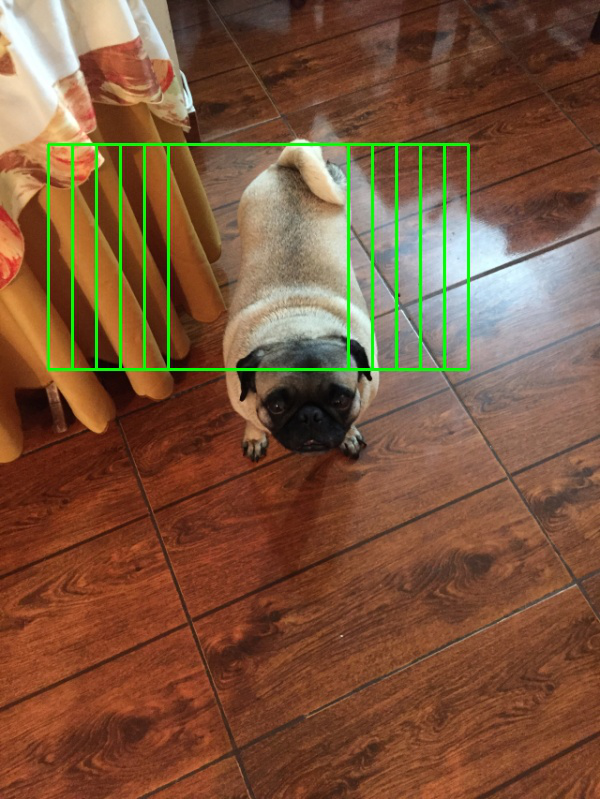

In [25]:
img = load_img("before_0.jpg")
img

And here's the result after applying NMS.

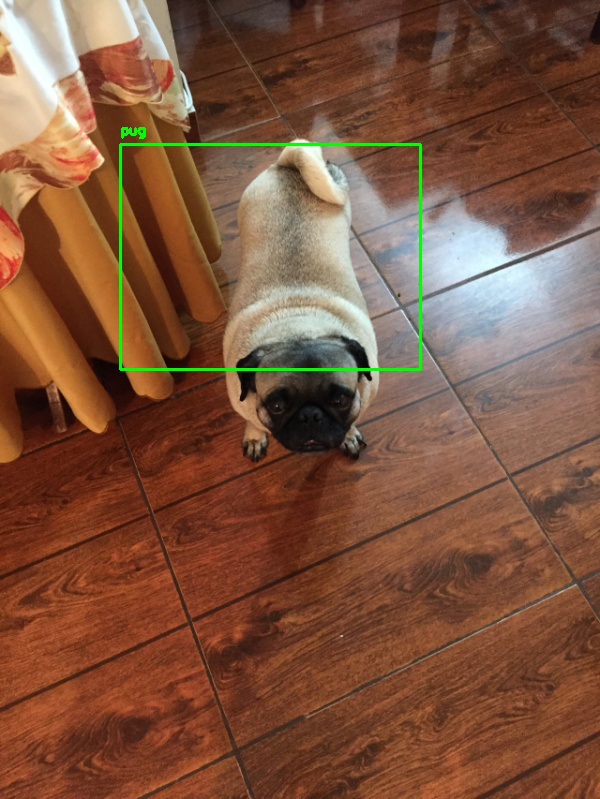

In [26]:
img = load_img("after_0.jpg")
img

##Take aways

Although we successfully detected the dog in the previous photos, we notice that the bounding box doesn't tightly wrap the object as nicely as we might have expected.

In this recipe, we implemented a reusable class that easily allows us to turn any image classifier into an object detector, by leveraging the iterative approach of extracting ROIs (sliding windows) at different levels of perspective (image pyramid) and passing them to such a classifier to determine where objects are in a photo, and what they are. Also, we used NMS to reduce the amount of non-informative, duplicate detections that are characteristic of this strategy.

Although this a great first attempt at creating an object detector, it has its flaws:

- It's incredibly slow, which makes it unusable in real-time situations.
- The accuracy of the bounding boxes depends heavily on the parameter selection for the image pyramid, the sliding window, and the ROI size.
- The architecture is not end-to-end trainable, which means that errors in
bounding-box predictions are not backpropagated through the network in order
to produce better, more accurate detections in the future, by updating its weights. Instead, we're stuck with pre-trained models that limit themselves to infer but not to learn because the framework does not allow them to.

However, don't rule out this approach yet! If you're working with images that present very little variation in size and perspective, and your application definitely doesn't operate in a real-time context, the strategy implemented in this recipe can work wonders for your project!